In [13]:
from pathlib import Path
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random

In [34]:
# Define Seeds
seed = 42
np.random.seed = seed


In [35]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [20]:
MODELS_PATH = Path(r"D:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\models")
TRAIN_PATH = Path(r"D:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\data\train")
TEST_PATH = Path(r"D:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\data\test") 

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype= np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype= np.bool)


In [23]:

print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
  path = str(TRAIN_PATH) + str('\\') + str(id_)
  img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS] # slice drops alpha channel
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode= "constant", preserve_range= True)
  X_train[n] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype= np.bool)
  for mask_file in next(os.walk(path + '/masks/'))[2]:
    mask_ = imread(path + '/masks/' + mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode= 'constant', preserve_range= True,), axis= -1) 
    mask = np.maximum(mask, mask_)
  
  y_train[n] = mask

Resizing training images and masks


100%|██████████| 670/670 [22:29<00:00,  2.01s/it]    


In [26]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = str(TEST_PATH) + str("/") + str(id_)
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:03<00:00, 20.33it/s]

Done!


C:\Users\alden\AppData\Local\Temp\ipykernel_10668\295192255.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[image_x])


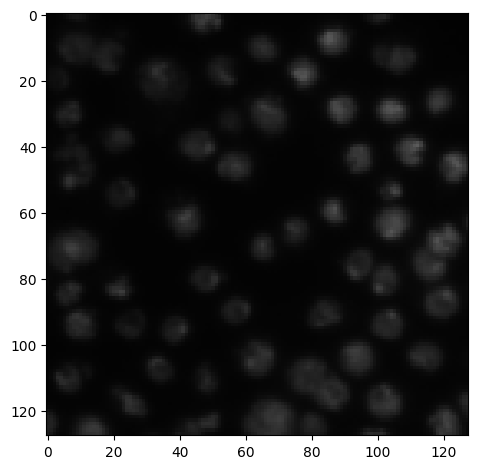

C:\Users\alden\AppData\Local\Temp\ipykernel_10668\295192255.py:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(y_train[image_x]))


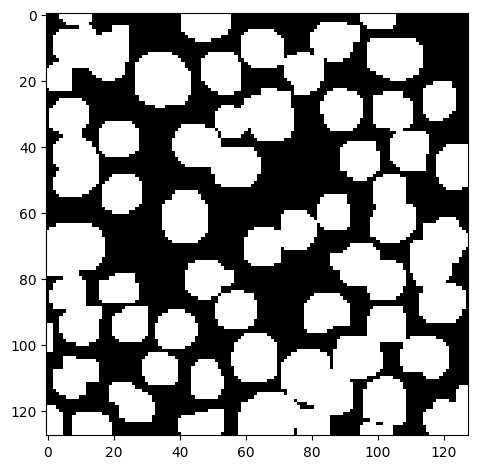

In [28]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [29]:
# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [30]:
# instantaite the model
model = tf.keras.Model(inputs= [inputs], outputs= [outputs])
model.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["accuracy"])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 128, 128,  │        448 │ lambda_3[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 128, 128,  │          0 │ conv2d_57[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_27[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64, 64,    │          0 │ conv2d_59[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_28[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32, 32,    │          0 │ conv2d_61[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_29[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 16, 16,    │          0 │ conv2d_63[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_30[0][0]

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    str(MODELS_PATH / "model_for_nuclei.keras"),
    verbose=1, 
    save_best_only=True
)

log_path = Path("D:/UCSD_CodeAlong_26_3_Image_Seg_U-Net/models/training_logs")

callbacks = [
    checkpointer,  # Add your existing checkpointer
    tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir=str(log_path))
] 

In [37]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)


X_train shape: (670, 128, 128, 3)
y_train shape: (670, 128, 128, 1)
Model input shape: (None, 128, 128, 3)
Model output shape: (None, 128, 128, 1)


In [38]:
results = model.fit(X_train, y_train, validation_split= 0.1, batch_size= 16, epochs= 25, callbacks= callbacks)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.7463 - loss: 0.5990

d:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_132']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 0.29323, saving model to D:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\models\model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 995ms/step - accuracy: 0.7465 - loss: 0.5968 - val_accuracy: 0.8194 - val_loss: 0.2932
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.8100 - loss: 0.3269
Epoch 2: val_loss improved from 0.29323 to 0.19238, saving model to D:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\models\model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 980ms/step - accuracy: 0.8113 - loss: 0.3258 - val_accuracy: 0.9337 - val_loss: 0.1924
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.9221 - loss: 0.2210
Epoch 3: val_loss improved from 0.19238 to 0.14865, saving model to D:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\models\model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 979ms/step - accuracy: 0.9222 - loss: 0.2204 - val_accuracy: 0.9393 - val_loss: 0.1486
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.

In [39]:
# Checking predicted values
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Use 0.5 as threshold for probability score
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


d:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_132']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step


C:\Users\alden\AppData\Local\Temp\ipykernel_10668\32694425.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[ix])


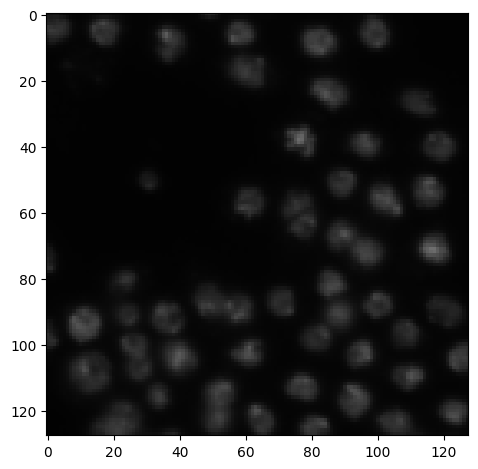

C:\Users\alden\AppData\Local\Temp\ipykernel_10668\32694425.py:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(y_train[ix]))


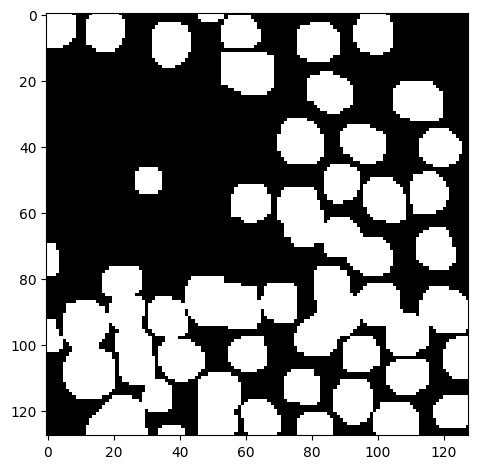

C:\Users\alden\AppData\Local\Temp\ipykernel_10668\32694425.py:7: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_train_t[ix]))
d:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


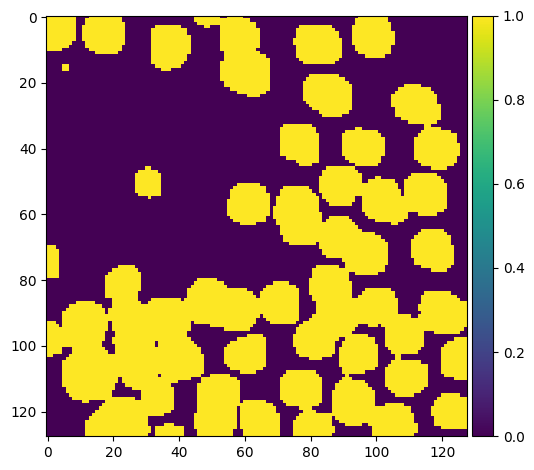

In [41]:
# Check a random instance of training data output
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


C:\Users\alden\AppData\Local\Temp\ipykernel_10668\3769778788.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[int(X_train.shape[0]*0.9):][ix])


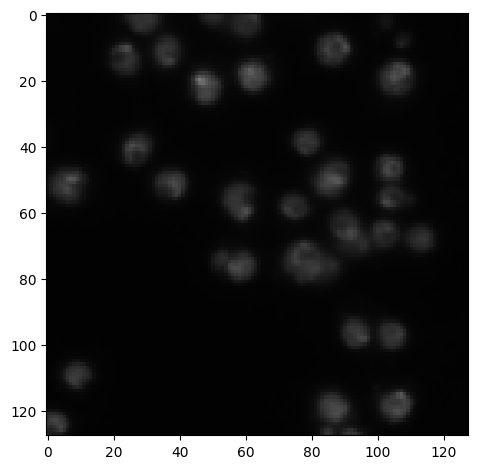

C:\Users\alden\AppData\Local\Temp\ipykernel_10668\3769778788.py:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))


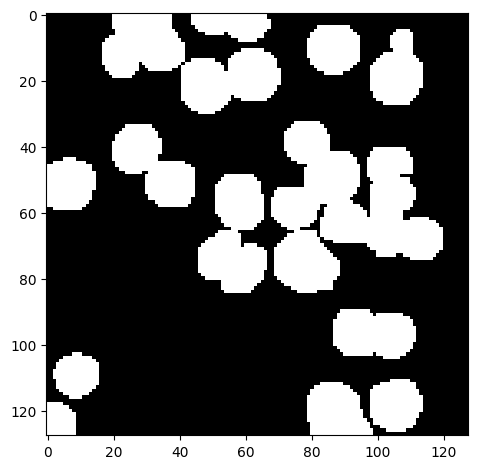

C:\Users\alden\AppData\Local\Temp\ipykernel_10668\3769778788.py:7: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_val_t[ix]))
d:\UCSD_CodeAlong_26_3_Image_Seg_U-Net\venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


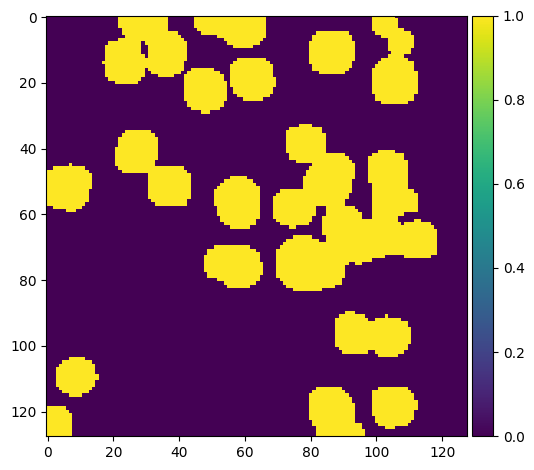

In [42]:
# Check a random instance of a test data output
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()